In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

PROJECT_ROOT_DIR = "."
CHAPTER_ID = "decision_trees"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

# 결정 트리 (DecisionTree)
SVM과 마찬가지로 분류, 회귀, 다중출력 모두 가능한 머신러닝 알고리즘이다.  
앙상블 학습에서 자주 이용되는 랜덤 포레스트의 기본 구성 요소인 결정 트리를 알아보자.

In [2]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
X = iris.data[:, 2:]
y = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2)
tree_clf.fit(X, y)

DecisionTreeClassifier(max_depth=2)

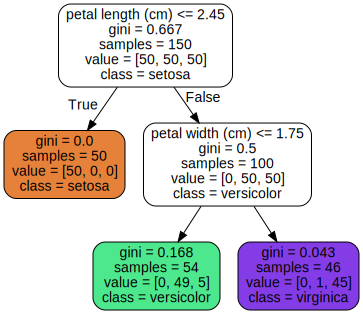

In [3]:
from graphviz import Source
from sklearn.tree import export_graphviz
import os

export_graphviz(
        tree_clf,
        out_file=os.path.join(IMAGES_PATH, "iris_tree.dot"),
        feature_names=iris.feature_names[2:],
        class_names=iris.target_names,
        rounded=True,
        filled=True
    )

Source.from_file(os.path.join(IMAGES_PATH, "iris_tree.dot"))


여기서 gini 속성은 불순도를 측정하는데, 한 노드에 모든 샘플이 같은 클래스에 속해 있다면 해당 노드를 순수하다고 한다.  
gini 점수를 계산하는 식은 다음과 같다.
\begin{equation}
    G_{i} = 1 - \sum^{n}_{k=1}(p_{i,k})^{2}
\end{equation}
결정 트리는 모델이 어떻게해서 그런 결정을 내렸는지 알 수 있다. 이를 **화이트 박스 모델**이라고 부르며  
반대로 신경망이나 랜덤포레스트와 같이 왜 이런 결정이 나왔는지 알기가 힘든 모델을 **블랙 박스 모델** 이라고 부른다.

## 클래스 확률 추정
Decision Tree는 한 샘플이 특정 클래스 $k$에 속할 확률을 추정할 수 있다.  
우선 결정 트리에서 한 샘플에 대하여 리프노드까지 들어간다.  
그 다음 도달한 리프 노드에서 해당 클래스에 속할 확률을 반환한다.

## CART 훈련 알고리즘
결정 트리를 훈련할때는 Classification And Regression Tree 알고리즘이 이용된다.  
먼저 훈련 세트를 하나의 특성 $k$의 임곗값 $t_{k}$를 사용하여 두개의 서브셋으로 나눈다.  
이때 특성 $k$와 임곗값 $t_{k}$을 고를 때, 가장 순수한 서브셋으로 나눌 수 있도록 진행한다.  
이 알고리즘이 최소화 해야하는 비용 함수는 다음과 같다.  
\begin{equation}
    J(k,t_{k}) = \frac{m_{left}}{m}G_{left} + \frac{m_{right}}{m}G_{right}
\end{equation}
<br>
여기서 $G_{left / right}$ 는 왼쪽/오른쪽 서브셋의 불순도이고 $m_{left / right}$는 왼쪽/오른쪽 서브셋의 샘플이다.  
이 과정을 최대 깊이 (max_depth 파라미터 맞다) 혹은 더이상 불순도를 줄이는 분할을 찾을 수 없을 때 까지 진행한다.

## 계산 복잡도

### 예측 과정
Decision Tree는 거의 균형 트리라고 알려져 있다. 그래서 한 샘플에 대해 리프노드 까지 탐색하는 과정은  
$O(\log_{2}(m))$ 번의 계산 과정을 거친다. 한 노드가 하나의 특성만 확인하므로 **전체 계산 복잡도 또한 $O(\log_{2}(m))$**이다

### 훈련 과정
훈련 알고리즘은 각 노드에서 모든 특성 (max_feature로 조정은 가능하다)을 비교한다.  
특성의 수를 $n$ 이라고 할 때 계산 복잡도는 $O(n * m\log_{2}{(m)})$ 이 된다.  
만약 데이터 셋이 작을 경우 사이킷런에서 presort=True로 둔다면 미리 데이터가 정렬되어 속도가 빨라진다.

## 엔트로피 불순도
보통은 지니 불순도가 이용되지만 criterion 매개변수를 entropy로 지정하면 엔트로피 불순도를 이용가능하다.
\begin{equation}
    H_{i} = -\sum_{k=1}^{n}p_{i,k}\log_{2}(p_{i,k}) \quad(where \;p_{i,k} \neq 0)
\end{equation}
지니 불순도와 엔트로피 불순도 모두 비슷한 트리를 만들어 내긴하지만 지니 불순도가 조금 더 계산이 빠르다.  
다만 다른 트리가 만들어 진다면 지니 불순도가 가장 빈도 높은 클래스를 한쪽 브랜치로 고립시키려는 경향이 있고  
엔트로피 불순도는 조금 더 균형있는 트리를 만들어 낸다.

## 결정 트리의 규제 파라미터
결정 트리는 시작하자마자 파라미터가 결정되지 않는다. 초기에는 제약이 거의 없는 셈. 이를 비파라미터 모델이라고 부른다.  
반면 선형 모델 같은 파라미터 모델은 미리 정의된 모델 파라미터를 이용하기에 과적합 우려는 없다.  
결정 트리에 규제 파라미터를 걸어서 과적합을 막아야하는데 사용할 규제 파라미터는 다음과 같다.

### max_depth
결정 트리의 최대 깊이를 제어해서 과적합을 막을 수 있다.  
초기값은 None으로 설정되어 있어서 제약이 없다.

### min_samples_split
분할되기 위해 노드가 가져야 하는 최소 샘플 수를 의미한다. 최소 샘플 수가 클 수록 트리가 분할되기가 힘들어진다.
<br>따라서 트리의 깊이가 깊어지는 것을 막을 수 있다.

### min_samples_leaf
리프 노드가 가지고 있어야 할 쵯소 샘플 수를 의미한다.  
최소 샘플 수가 크다면 좀 더 위쪽에서 트리의 분할이 종료되므로 트리의 깊이가 얕아진다.

### min_weight_fraction_leaf
min_samples_leaf 와 같지만 리프 노드가 되기 위한 가중치가 부여된 전체 샘플 수에서의 비율이다.

### max_leaf_nodes
트리의 리프 노드의 최대 수를 의미한다.

### max_features
각 노드가 분할될 때 사용할 특성의 최대 숫자이다.

### 가지치기
순도를 높이는 것이 효과가 없다면 해당 노드뿐만 아니라 상위 노드도 불필요할 수 있다.  
$\chi^{2}$ 검정같은 검정을 사용하여 우연히 향상됬는지 추정한다.  
여기서 얻게 되는 p-값이 어떤 임곗값 (보통 5%) 보다 크다면 우연의 의한것으로 간주되어 불필요하다 판단, 삭제된다.  
(추가로 $\chi^{2}$의 값이 커지면 p-값이 줄어든다)

## 회귀
Decision Tree는 회귀 문제에도 이용이 가능하다. 사이킷런의 DecisionTreeRegressor를 이용하면 된다.  

In [4]:
from sklearn.tree import DecisionTreeRegressor

np.random.seed(42)
m = 200
X = np.random.rand(m, 1)
y = 4 * (X - 0.5)**2
y = y + np.random.randn(m, 1) / 10

tree_reg = DecisionTreeRegressor(max_depth=2)
tree_reg.fit(X, y)

DecisionTreeRegressor(max_depth=2)

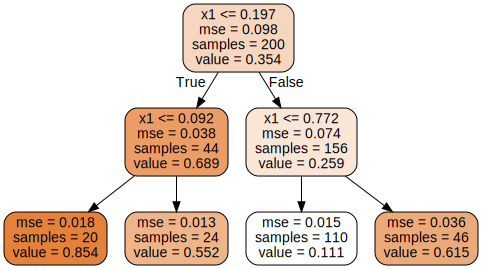

In [7]:
export_graphviz(tree_reg,
                out_file=os.path.join(IMAGES_PATH, "regression_tree.dot"),
                feature_names=["x1"],
                rounded=True,
                filled=True)
Source.from_file(os.path.join(IMAGES_PATH, "regression_tree.dot"))

DecisionTree는 리프 노드마다의 구간별 평균 타깃값을 예측값으로 반환하여 준다.  
예를들어 x1 == 0.6이였다면 value가 0.111인 리프 노드에 도달하게 된다.  
또한 max_depth 가 깊어질 수록 구간을 좀 더 분할 할수있게 된다.  
회귀에서 CART 알고리즘은 훈련 세트의 불순도 최소화가 아닌 MSE를 최소화하도록 분할한다.  
<br>
\begin{equation}
   J(k,t_{k})=\frac{m_{left}}{m}MSE_{left} + \frac{m_{right}}{m}MSE_{right}
\end{equation}
<br>
\begin{equation}
   여기서\begin{cases}
    MSE_{node} = \frac{1}{m_{node}}\sum_{i\in{node}}\;(\hat{y}_{node}-y^{(i)})^{2}\\
    \hat{y}_{node} = \frac{1}{m_{node}}\sum_{i\in{node}}y^{(i)}
    \end{cases}
\end{equation}
<br>
회귀에서도 마찬가지로 규제 파라미터를 지정해줘야만 과대적합을 막을 수 있다.

## DecisionTree의 불안정성
DecisionTree의 결정 경계는 계단 모양 형태로 형성된다.  
그렇기에 훈련 세트가 회전하는 순간 경계가 구불구불해지면서 정확도가 떨어질 수 있다.  
(물론 이 경우에는 가장 최적의 회전값을 찾는 PCA 방식이 존재한다)  
또한 훈련 데이터에 있는 작은 변화에도 크게 민감해지는데 특정 데이터 샘플의 존재 여부에 따라 결정 경계가 크게  
달라질 수 있기에 많은 트리에서 만든 예측을 평균하여 구하는 방식이 각광을 받게 된다.